<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [ ]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 63134054, 'trade_mode': 2, 'leverage': 100, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 57.46, 'credit': 13.06, 'profit': 0.0, 'equity': 70.52, 'margin': 0.0, 'margin_free': 70.52, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'Bright Idowu ', 'server': 'OctaFX-Real', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': False, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5370, 'maxbars': 100000000, 'codepage': 0, 'ping_last': 1988

In [ ]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

70.52
AI is successfully functional


In [ ]:
t_s = "GBPUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M15, 0, 10000000)
#display(market)
print(market.shape)

print(t_s)




(666341,)
GBPUSD


In [ ]:
market

array([( 737164800, 1.537  , 1.5445 , 1.529  , 1.5338 , 2781, 50, 0),
       ( 737251200, 1.5328 , 1.536  , 1.518  , 1.5225 , 2571, 50, 0),
       ( 737337600, 1.5228 , 1.5415 , 1.52   , 1.5387 , 2711, 50, 0), ...,
       (1762557300, 1.31634, 1.31646, 1.31587, 1.31601,  636, 14, 0),
       (1762558200, 1.31602, 1.31604, 1.31543, 1.31545,  419, 14, 0),
       (1762559100, 1.31543, 1.31626, 1.31523, 1.31573, 2185, 14, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [ ]:
data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4],market[i][5]])
df = pd.DataFrame(data, columns=["open", "high","low", "close","volume"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
t_symbol = ["BTCUSD"]

In [8]:


def engineer_features_5min_btc(df):
    # --- Exponential Moving Averages ---
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

    # --- Simple Moving Average (20) ---
    df['MA_20'] = df['close'].rolling(window=20).mean()

    # --- RSI (14) ---
    delta = df['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # --- Bollinger Bands (20-period) ---
    df['BB_Middle'] = df['close'].rolling(window=20).mean()
    df['BB_Std'] = df['close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
    df['BB_%B'] = (df['close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

    # --- Clean up and drop NaNs (first ~200 rows) ---
    df = df.dropna().reset_index(drop=True)

    return df

# Usage:
# df = pd.read_csv('btcusd_5min.csv')
# df = engineer_features_5min_btc(df)

In [9]:
n = 0
m_label = "Generated"+t_symbol[n]
#pd.set_option('display.float_format', '{:.20f}'.format)

train_df = pd.read_csv(m_label+ " dbot.csv")
train_df = engineer_features_5min_btc(train_df)
max_val = train_df.max()
print(max_val)
train_df = train_df/max_val
#train_df = engineer_features_5min_btc(train_df)[10:]

open         126096.180000
high         126290.500000
low          125932.500000
close        126096.690000
volume        83851.000000
EMA_50       125430.865689
EMA_200      124817.815380
MA_20        125654.336500
RSI_14          100.000000
BB_Middle    125654.336500
BB_Std         3005.493638
BB_Upper     126134.971157
BB_Lower     125225.057740
BB_%B             1.561606
dtype: float64


In [10]:
train_df

,open,high,low,close,volume,EMA_50,EMA_200,MA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,BB_%B
0,0.000079,0.000082,0.000075,0.000079,0.002147,0.000099,0.000106,0.000094,0.340946,0.000094,0.000828,0.000133,0.000055,0.199513
1,0.000079,0.000083,0.000067,0.000075,0.004281,0.000098,0.000106,0.000093,0.323899,0.000093,0.000835,0.000132,0.000053,0.180486
2,0.000075,0.000078,0.000071,0.000075,0.002135,0.000097,0.000106,0.000091,0.335778,0.000091,0.000834,0.000130,0.000051,0.193849
3,0.000075,0.000081,0.000074,0.000080,0.001527,0.000096,0.000105,0.000090,0.369683,0.000090,0.000820,0.000128,0.000051,0.246779
4,0.000080,0.000089,0.000076,0.000086,0.003077,0.000096,0.000105,0.000088,0.399410,0.000088,0.000792,0.000126,0.000051,0.299968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724764,0.817154,0.817386,0.818037,0.818448,0.018533,0.821184,0.819258,0.820018,0.608021,0.820018,0.045555,0.819064,0.820642,0.512928
724765,0.818519,0.817560,0.818605,0.817840,0.019809,0.821223,0.819328,0.820088,0.526517,0.820088,0.045462,0.819129,0.820717,0.413149
724766,0.817851,0.816967,0.818163,0.817290,0.016303,0.821239,0.819391,0.820095,0.466996,0.820095,0.045462,0.819137,0.820724,0.330769
724767,0.817317,0.816359,0.817398,0.817094,0.016661,0.821246,0.819451,0.820107,0.454801,0.820107,0.045350,0.819143,0.820741,0.300121


In [11]:

#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 60 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape


X, y = create_sequences(train_df.values, SEQ_LEN, 5, 7 )
train_df = None
n_samples = X.shape[0]
#print(X[-1])
print(y[-1])

GeneratedBTCUSD
[0.8200177  0.82008761 0.82009517 0.82010652 0.820126  ]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)
X = None
y = None

In [13]:

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))

X = Bidirectional(LSTM(64, return_sequences=True))(i)

X = Bidirectional(LSTM(64, return_sequences=True))(X)
X = Dropout(0.3)(X)

X = Bidirectional(LSTM(32))(X)
X = Dropout(0.3)(X)

X = Dense(32, activation="relu")(X)
X = Dropout(0.3)(X)

X = Dense(output_dim, activation="linear")(X)

model = Model(i, X)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,725 (713.77 KB)

 Trainable params: 182,725 (713.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=4096,
  callbacks=[es, rlr, mc ],
  verbose=1

)

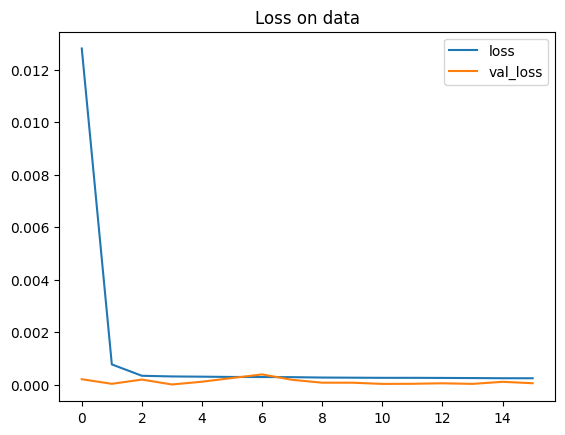

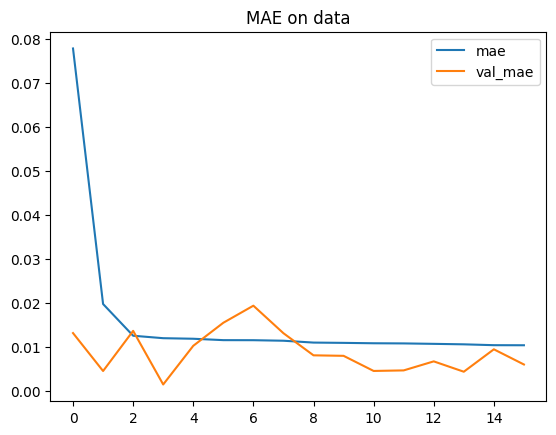

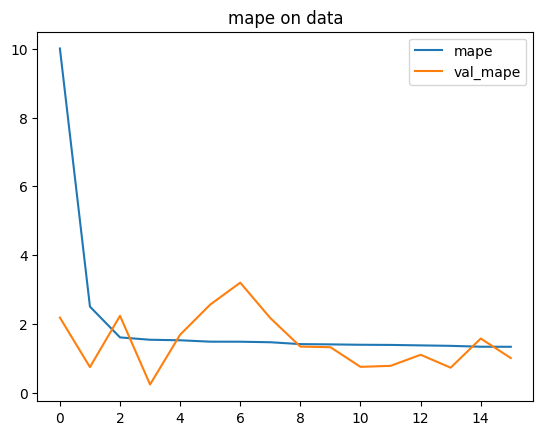

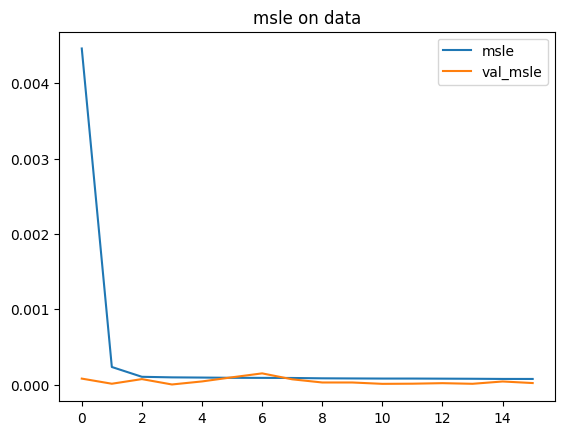

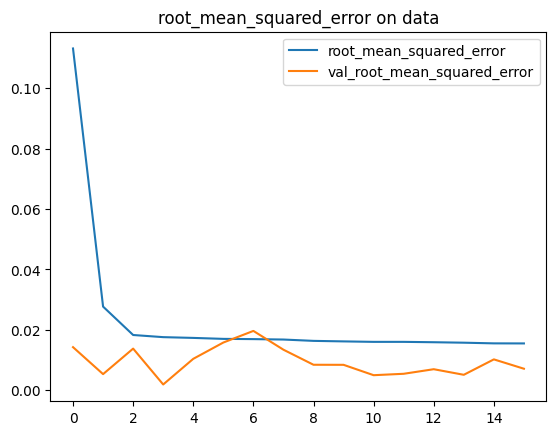

In [ ]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [ ]:
m_label = "GeneratedGBPUSD"
best_model = load_model(m_label + 'lstm_best.keras')

In [ ]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 240, 128)       │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 240, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 240, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,520,267 (5.80 MB)

 Trainable params: 506,755 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,013,512 (3.87 MB)

In [ ]:
y_pred = best_model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


In [ ]:
print(y_pred.shape)

(2199, 3)


In [ ]:
#_,y_test = inverse_transform_data(scaled_y=y_test)
#_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[0.63505818 0.63499196 0.63491628]
 [0.63499196 0.63491628 0.63491628]
 [0.63491628 0.63491628 0.63493047]
 ...
 [0.62262321 0.62258538 0.62261848]
 [0.62258538 0.62261848 0.62246713]
 [0.62261848 0.62246713 0.62218806]]  comparing to  [[0.63622403 0.6365929  0.63619727]
 [0.6362174  0.63658625 0.6361908 ]
 [0.63621604 0.6365853  0.63618946]
 ...
 [0.6220507  0.6224401  0.6220193 ]
 [0.6220033  0.6223934  0.6219719 ]
 [0.62199366 0.6223837  0.6219622 ]]


In [ ]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")



Average Gap (Bias): -0.0016482

--- Example of Correction ---
Original Prediction: 0.6362240
Corrected Prediction: 0.6345759
Actual Value:        0.6350582


In [ ]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred))
print(r2_score(y_test, y_pred_corrected))

R^2 value for  GeneratedGBPUSD
0.8757254939381127
0.9558976108941962


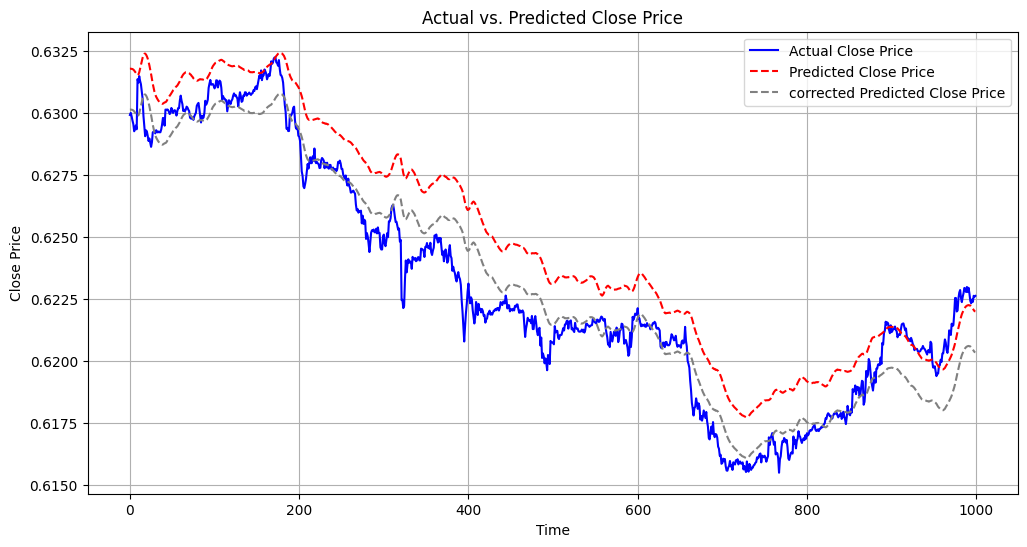

In [ ]:




plt.figure(figsize=(12, 6))
plt.plot(y_test[-1000:, 0], label='Actual Close Price', color='blue')
plt.plot(y_pred[-1000:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[-1000:, 0], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()
